<a href="https://colab.research.google.com/github/dk-wei/tensorflow-dojo/blob/main/tf_keras_to_estimator%26feature_column.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
# !python -m pip install -U pip
# !pip -V
# !pip install sklearn pandas

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [ ]:
!wget https://storage.googleapis.com/tf-datasets/titanic/train.csv
!wget https://storage.googleapis.com/tf-datasets/titanic/eval.csv

--2021-08-07 02:36:57--  https://storage.googleapis.com/tf-datasets/titanic/train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c02::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30874 (30K) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  30.15K  --.-KB/s    in 0s      

2021-08-07 02:36:57 (75.0 MB/s) - ‘train.csv’ saved [30874/30874]

--2021-08-07 02:36:57--  https://storage.googleapis.com/tf-datasets/titanic/eval.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13049 (13K) [application/octet-stream]
Saving to: ‘eval.csv’

eval.csv            

In [ ]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv

train_file = 'train.csv'
eval_file = 'eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
   survived     sex   age  ...     deck  embark_town  alone
0         0    male  35.0  ...  unknown  Southampton      y
1         0    male  54.0  ...        E  Southampton      y
2         1  female  58.0  ...        C  Southampton      y
3         1  female  55.0  ...  unknown  Southampton      y
4         1    male  34.0  ...        D  Southampton      y

[5 rows x 10 columns]


In [ ]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]
      sex   age  n_siblings_spouses  parch  ...   class     deck  embark_town alone
0    male  35.0                   0      0  ...   Third  unknown  Southampton     y
1    male  54.0                   0      0  ...   First        E  Southampton     y
2  female  58.0                   0      0  ...   First        C  Southampton     y
3  female  55.0                   0      0  ...  Second  unknown  Southampton     y
4    male  34.0                   0      0  ...  Second     

In [ ]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


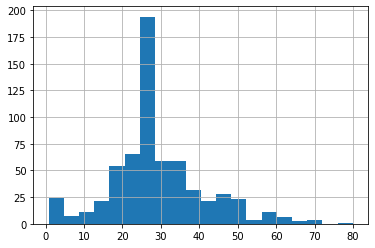

In [ ]:
train_df.age.hist(bins=20)

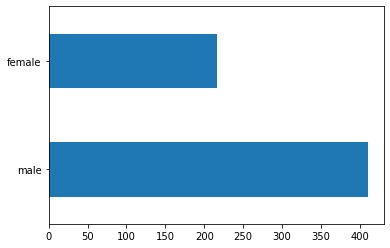

In [ ]:
train_df.sex.value_counts().plot(kind='barh')

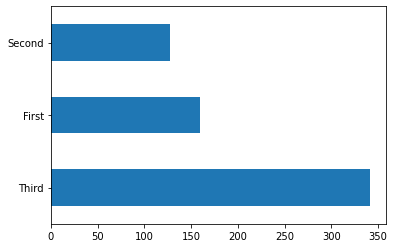

In [ ]:
train_df['class'].value_counts().plot(kind='barh')

In [ ]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean()

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64

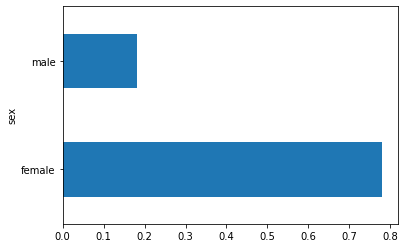

In [ ]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

# `tf.feature_column`数据封装 (教学视频，相对拧巴)

见[教学视频](https://www.youtube.com/watch?v=GRNDD37pdec&list=PLFI1Cd4723_RLWCCLVw35l03Om4tamUMW&index=54)



## 定义特征列

常用手段就是，处理numeric和categorical feature，然后放入feature_columns这个list当中

In [ ]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']


feature_columns = []

# 处理categorical变量
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)

    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)
            )
        )

# 处理numeric变量
for numeric_column in numeric_columns:

    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32
            )
        )

# cross feature: age: [1,2,3,4,5], gender: [male, female]
# age_x_gender: [(1, male), (2, male), ..., (5, male), ..., (5, female)]
# 100000: 100 -> hash(100000 values) % 100

feature_columns.append(
    tf.feature_column.indicator_column(
        tf.feature_column.crossed_column(
            ['age', 'sex'], hash_bucket_size=100)))

from pprint import pprint
pprint(feature_columns)

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']
[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCa

In [ ]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [ ]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [ ]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'female', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 31., 32., 45., 16.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 0])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 7.55, 57.  ,  7.75,  8.05, 26.  ])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'Third', b'Third', b'Second'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'B', b'unknown', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Queenstown', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'n', b'y', b'y', b'y'], dtype=

In [ ]:
# keras.layers.DenseFeature 示例1
for x,y in train_dataset.take(1):
    print(x, y)
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'female', b'female', b'male', b'female', b'female'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([32., 35., 26.,  9., 14.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 2, 4, 1])>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 2, 2])>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 13.    ,  53.1   ,   8.6625,  31.275 , 120.    ])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Second', b'First', b'Third', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'C', b'unknown', b'unknown', b'B'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y', b'n', b'n', b'n

In [ ]:
# keras.layers.DenseFeature 示例2
for x,y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

[[44.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      1.      1.      0.      0.      1.      0.
   0.      0.      0.      0.      0.      0.      1.      0.      0.
   0.      7.925   0.      1.      0.      0.      0.      0.      0.
   1.      0.      0

## 定义模型

In [ ]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(learning_rate=0.01),
             metrics=['accuracy'])

In [ ]:
# 1. model.fit
# 2. model ->estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)

history = model.fit(train_dataset, validation_data=eval_dataset,
                   steps_per_epoch=20,
                   validation_steps=8,
                   epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/20 [>.............................] - ETA: 21s - loss: 1.9892 - accuracy: 0.7500WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'sex': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'n_siblings_spouses': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'parch': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int64>, 'fare': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'class': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'deck': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'embark_town': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'alone': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functi

### 自定义模型转变为estimator

In [ ]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. return a. (features, lables) b.dataset -> (feture, label)
estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpio4cjjda', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


ValueError: ignored

### 预定义estimator

#### baseline_estimator

In [ ]:
output_dir = 'baseline_model_new_features'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
baseline_estimator = tf.compat.v1.estimator.BaselineClassifier(
    model_dir = output_dir,
    n_classes = 2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'baseline_model_new_features', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
baseline_estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into baseline_model_new_features/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 22.18071, step = 0
INFO:tensorflow:global_step/sec: 613.392
INFO:tensorflow:loss = 21.628849, step = 100 (0.168 sec)
INFO:tensorflow:global_step/sec: 907.86
INFO:tensorflow:loss = 20.321535, step = 200 (0.107 sec)
INFO:tensorflow:global_step/sec: 951.079
INFO:tensorflow:loss = 21.65068, step = 300 (0.107 sec)
INFO:tensorflow:global_step/sec: 810.251
IN

In [ ]:
baseline_estimator.evaluate(input_fn = lambda : make_dataset(
    eval_df, y_eval, epochs = 1, shuffle=False, batch_size=20))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-07T02:37:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from baseline_model_new_features/model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.50465s
INFO:tensorflow:Finished evaluation at 2021-08-07-02:37:14
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.625, accuracy_baseline = 0.625, auc = 0.5, auc_precision_recall = 0.6875, average_loss = 0.66190374, global_step = 1960, label/mean = 0.375, loss = 12.481613, precision = 0.0, prediction/mean = 0.3876884, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1960: baseline_model_new_features/model.ckpt-1960


{'accuracy': 0.625,
 'accuracy_baseline': 0.625,
 'auc': 0.5,
 'auc_precision_recall': 0.6875,
 'average_loss': 0.66190374,
 'global_step': 1960,
 'label/mean': 0.375,
 'loss': 12.481613,
 'precision': 0.0,
 'prediction/mean': 0.3876884,
 'recall': 0.0}

#### linear_estimator

In [ ]:
linear_output_dir = 'linear_model_new_features'
if not os.path.exists(linear_output_dir):
    os.mkdir(linear_output_dir)
    
linear_estimator = tf.compat.v1.estimator.LinearClassifier(
    model_dir = linear_output_dir,
    n_classes = 2,
    feature_columns = feature_columns)

linear_estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'linear_model_new_features', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into linear_model_new_features/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 22.18071, step = 0
INFO:tensorflow:global_step/sec: 386.673
INFO:tensorflow:loss = 9.59732, step = 100 (0.265 sec)
INFO:tensorflow:global_step/sec: 718.909
INFO:tensorflow:loss = 13.097073, step = 200 (0.138 sec)
INFO:tensorflow:global_step/sec: 669.193
INFO:tensorflow:loss = 9.508378, step = 300 (0.151 sec)
INFO:tensorflow:global_step/sec: 667.507
INFO:tensorflow:loss = 14.157634, step = 400 (0.149 sec)
INFO:tensorflow:global_step/sec: 715.894
INFO:tensorflow:loss = 12.124954, step = 500 (0.135 sec)
INFO:tensorflow:global_step/sec: 72

##### 开启Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
!kill 4829
# %tensorboard --logdir='/content/linear_model_new_features'

/bin/bash: line 0: kill: (4829) - No such process


In [ ]:
linear_estimator.evaluate(input_fn = lambda : make_dataset(
    eval_df, y_eval, epochs = 1, shuffle=False, batch_size=20))

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-07T02:37:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from linear_model_new_features/model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.61294s
INFO:tensorflow:Finished evaluation at 2021-08-07-02:37:22
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.79924244, accuracy_baseline = 0.625, auc = 0.8554331, auc_precision_recall = 0.7781254, average_loss = 0.48924416, global_step = 1960, label/mean = 0.375, loss = 9.225747, precision = 0.7090909, prediction/mean = 0.42855167, recall = 0.7878788
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1960: linear_model_new_features/model.ckpt-1960


{'accuracy': 0.79924244,
 'accuracy_baseline': 0.625,
 'auc': 0.8554331,
 'auc_precision_recall': 0.7781254,
 'average_loss': 0.48924416,
 'global_step': 1960,
 'label/mean': 0.375,
 'loss': 9.225747,
 'precision': 0.7090909,
 'prediction/mean': 0.42855167,
 'recall': 0.7878788}

#### dnn_estimator

In [ ]:
dnn_output_dir = 'dnn_model_new_features'
if not os.path.exists(dnn_output_dir):
    os.mkdir(dnn_output_dir)
    
dnn_estimator = tf.compat.v1.estimator.DNNClassifier(
    model_dir = dnn_output_dir,
    n_classes = 2,
    feature_columns = feature_columns,
    hidden_units = [128, 128],
    activation_fn = tf.nn.relu,
    optimizer = 'Adam')

dnn_estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'dnn_model_new_features', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
IN

In [ ]:
dnn_estimator.evaluate(input_fn = lambda : make_dataset(
    eval_df, y_eval, epochs = 1, shuffle=False, batch_size=20))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-07T02:37:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from dnn_model_new_features/model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.70997s
INFO:tensorflow:Finished evaluation at 2021-08-07-02:37:30
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.7878788, accuracy_baseline = 0.625, auc = 0.8299663, auc_precision_recall = 0.78643703, average_loss = 0.5346569, global_step = 1960, label/mean = 0.375, loss = 10.082101, precision = 0.70873785, prediction/mean = 0.46749967, recall = 0.7373737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1960: dnn_model_new_features/model.ckpt-1960


{'accuracy': 0.7878788,
 'accuracy_baseline': 0.625,
 'auc': 0.8299663,
 'auc_precision_recall': 0.78643703,
 'average_loss': 0.5346569,
 'global_step': 1960,
 'label/mean': 0.375,
 'loss': 10.082101,
 'precision': 0.70873785,
 'prediction/mean': 0.46749967,
 'recall': 0.7373737}

# `tf.feature_column`数据封装 (官方文档改编，更推荐)

见[官方文档](https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=zh-cn)链接


大致流程：
1. tf.data封装数据
2. 转为numeric和categorical特征列
3. 放入feature_columns
4. 再装入tf.keras.layers.DenseFeatures()
5. 投入模型

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
train_file = 'train.csv'
eval_file = 'eval.csv'

train = pd.read_csv(train_file)
test = pd.read_csv(eval_file)

print(train.head())
print(test.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
   survived     sex   age  ...     deck  embark_town  alone
0         0    male  35.0  ...  unknown  Southampton      y
1         0    male  54.0  ...        E  Southampton      y
2         1  female  58.0  ...        C  Southampton      y
3         1  female  55.0  ...  unknown  Southampton      y
4         1    male  34.0  ...        D  Southampton      y

[5 rows x 10 columns]


In [ ]:
#train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)  # 从training data中提取val data

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

501 train examples
126 validation examples
264 test examples


In [ ]:
train.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
93,0,male,24.0,0,1,247.5208,First,B,Cherbourg,n
581,0,male,28.0,0,0,6.9500,Third,unknown,Queenstown,y
361,0,female,37.0,0,0,9.5875,Third,unknown,Southampton,y
294,0,male,21.0,0,0,7.7750,Third,unknown,Southampton,y
240,0,male,38.0,0,1,153.4625,First,C,Southampton,n


## 先用`tf.data`封装`pandas dataframe`数据

接下来，我们将使用 `tf.data` 包装 `datafram`e。这让我们能将特征列作为一座桥梁，该桥梁将 `Pandas dataframe` 中的列映射到用于训练模型的特征。如果我们使用一个非常大的 CSV 文件（非常大以至于它不能放入内存），我们将使用 `tf.data` 直接从磁盘读取它。本教程不涉及这一点。

可以进行shuffle等操作

- `tf.data.Dataset.from_tensor_slices`


In [ ]:
# 一种从 Pandas Dataframe 创建 tf.data 数据集的实用程序方法（utility method）

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('survived')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))   # 采用from_tensor_slices读取dataframe数据
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
batch_size = 5 # 小批量大小用于演示

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
# 展示一些tf.data分装好了的feature，要用到take
# 每个显示的是一个batch，5个数据

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['age'])
  print('A batch of embark_town:', feature_batch['embark_town'])
  print('A batch of targets:', label_batch )

Every feature: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of ages: tf.Tensor([28. 37. 41. 28. 29.], shape=(5,), dtype=float64)
A batch of embark_town: tf.Tensor([b'Queenstown' b'Cherbourg' b'Southampton' b'Queenstown' b'Cherbourg'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([0 0 0 1 1], shape=(5,), dtype=int64)


## 演示特征列

In [ ]:
# 我们将使用该batch数据演示几种特征列
example_batch = next(iter(train_ds))[0]

In [ ]:
# 用于创建一个特征列
# 并转换一批次数据的一个实用程序方法
def demo(feature_column):
  feature_layer = keras.layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

### Numerical Column

一个特征列的输出将成为模型的输入（使用上面定义的 demo 函数，我们将能准确地看到 dataframe 中的每列的转换方式）。 数值列（numeric column） 是最简单的列类型。它用于表示实数特征。使用此列时，模型将从 dataframe 中接收未更改的列值。

- feature_column.numeric_column("age")

In [ ]:
age = feature_column.numeric_column("age")
demo(age)

[[26.]
 [30.]
 [31.]
 [28.]
 [19.]]


#### Normalization

Numerical data可能唯一要做的就是normalization吧

In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

photo_count_col = train['age']
layer = get_normalization_layer('age', train_ds)
#layer(photo_count_col).numpy()

### Numerical-Bucketized Column

通常，您不希望将数字直接输入模型，而是根据数值范围将其值分成不同的类别。考虑代表一个人年龄的原始数据。我们可以用 分桶列（bucketized column）将年龄分成几个分桶（buckets），而不是将年龄表示成数值列。请注意下面的 one-hot 数值表示每行匹配的年龄范围。

- feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [ ]:
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Categorical Column

在此数据集中，thal 用字符串表示（如 'fixed'，'normal'，或 'reversible'）。我们无法直接将字符串提供给模型。相反，我们必须首先将它们映射到数值。分类词汇列（categorical vocabulary columns）提供了一种用 one-hot 向量表示字符串的方法（就像您在上面看到的年龄分桶一样）。词汇表可以用 categorical_column_with_vocabulary_list 作为 list 传递，或者用 categorical_column_with_vocabulary_file 从文件中加载。

- feature_column.categorical_column_with_vocabulary_list('embark_town', train.embark_town.unique())
- feature_column.indicator_column(n_siblings_spouses)

In [ ]:
# embark_town
embark_town = feature_column.categorical_column_with_vocabulary_list(
      'embark_town', train.embark_town.unique())    # 注意我们要提供unique value

In [ ]:
# n_siblings_spouses
n_siblings_spouses = feature_column.categorical_column_with_vocabulary_list(
      'n_siblings_spouses', train.n_siblings_spouses.unique())

n_siblings_spouses_one_hot = feature_column.indicator_column(n_siblings_spouses)
demo(n_siblings_spouses_one_hot)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


#### Multi-variable Categorical Column (多值离散特征)

In [ ]:
import tensorflow as tf
#from tensorflow.python.feature_column import feature_column
#tf.enable_eager_execution()

# 定义所有球员的集合
TAG_SET = ["harden", "james", "curry", "durant", "paul","towns","wrestbrook"]

# 假设现在有三个用户，用户a, b和c，各自喜欢不同的球员 
PLAYER_DATA = {'players': [['harden', 'james', 'curry'], 
                           ['wrestbrook', 'harden', 'durant'],
                           ['james', 'paul', 'towns']
                           ]}


player_column = tf.feature_column.categorical_column_with_vocabulary_list(
    'players', TAG_SET, dtype=tf.string, default_value=-1
)

embedding_column = tf.feature_column.embedding_column(player_column, 3, combiner='mean')

column_input_layer = tf.compat.v1.feature_column.input_layer(PLAYER_DATA, [embedding_column])
print(column_input_layer)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[ 0.17541592 -0.1932693  -0.1912862 ]
 [ 0.4165666  -0.3265413  -0.07012107]
 [-0.18271618  0.02266    -0.5377717 ]], shape=(3, 3), dtype=float32)


### Embedding Column

假设我们不是只有几个可能的字符串，而是每个类别有数千（或更多）值。 **由于多种原因，随着类别数量的增加，使用 one-hot 编码训练神经网络变得不可行**。我们可以使用嵌入列来克服此限制。嵌入列（embedding column）将数据表示为一个低维度密集向量，而非多维的 one-hot 向量，该低维度密集向量可以包含任何数，而不仅仅是 0 或 1。嵌入的大小（在下面的示例中为 8）是必须调整的参数。

关键点：**当分类列具有许多可能的值时，最好使用嵌入列(embedding column)**。我们在这里使用嵌入列用于演示目的，为此您有一个完整的示例，以在将来可以修改用于其他数据集。

In [ ]:
# 注意到嵌入列的输入是我们之前创建的类别列
n_siblings_spouses_embedding = feature_column.embedding_column(n_siblings_spouses, dimension=4)
demo(n_siblings_spouses_embedding)

[[ 0.15827657 -0.2708142   0.09993475 -0.3487684 ]
 [ 0.15827657 -0.2708142   0.09993475 -0.3487684 ]
 [ 0.773581   -0.4492442   0.02946871 -0.5633131 ]
 [ 0.15827657 -0.2708142   0.09993475 -0.3487684 ]
 [ 0.15827657 -0.2708142   0.09993475 -0.3487684 ]]


### Hash Column

表示具有大量数值的分类列的另一种方法是使用 categorical_column_with_hash_bucket。该特征列计算输入的一个哈希值，然后选择一个 hash_bucket_size 分桶来编码字符串。使用此列时，您不需要提供词汇表，并且可以选择使 hash_buckets 的数量远远小于实际类别的数量以节省空间。

关键点：该技术的一个重要缺点是可能存在冲突，不同的字符串被映射到同一个范围。实际上，无论如何，经过哈希处理的特征列对某些数据集都有效。

In [ ]:
# 注意feature不能是numerical feature，只能是非数字的categorical feature
embark_town_hashed = feature_column.categorical_column_with_hash_bucket(
      'embark_town', hash_bucket_size=1000)

demo(feature_column.indicator_column(embark_town_hashed))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Cross Feature Column

将多种特征组合到一个特征中，称为特征组合（feature crosses），它让模型能够为每种特征组合学习单独的权重。此处，我们将创建一个 age 和 thal 组合的新特征。请注意，crossed_column 不会构建所有可能组合的完整列表（可能非常大）。相反，它由 hashed_column 支持，因此您可以选择表的大小。

- cross_features: age:[1, 2, 3, 4, 5], gender: ['male', 'female']
- age_x_gender: [(1, male), (2, male), (3, male)..., (1, female), (2, female)...]


In [ ]:
crossed_feature = feature_column.crossed_column([age_buckets, embark_town], hash_bucket_size=1000)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 正式定义特征列

我们已经了解了如何使用几种类型的特征列。 现在我们将使用它们来训练模型。本教程的目标是向您展示使用特征列所需的完整代码（例如，机制）。我们任意地选择了几列来训练我们的模型。

关键点：如果您的目标是建立一个准确的模型，请尝试使用您自己的更大的数据集，并仔细考虑哪些特征最有意义，以及如何表示它们。

上面演示过了，现在我们可以把不同的feature放入不同的类别，最后把所有的feature都放入**`feature columns`**里面

In [ ]:
# 把生成的各种feature都放入feature column里面
feature_columns = []

# 数值列
for header in ['age', 'fare']:
  feature_columns.append(feature_column.numeric_column(header))

# 分桶列
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 分类列
n_siblings_spouses = feature_column.categorical_column_with_vocabulary_list(
      'n_siblings_spouses', train.n_siblings_spouses.unique())
n_siblings_one_hot = feature_column.indicator_column(n_siblings_spouses)
feature_columns.append(n_siblings_one_hot)

# 嵌入列
n_siblings_spouses_embedding = feature_column.embedding_column(n_siblings_spouses, dimension=8)
feature_columns.append(n_siblings_spouses_embedding)

# 组合列
crossed_feature = feature_column.crossed_column([age_buckets, embark_town], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

### 建立一个新的特征层 (` tf.keras.layers.DenseFeatures(feature_columns)`)

现在我们已经定义了我们的特征列，我们将使用密集特征（DenseFeatures）层将特征列输入到我们的 Keras 模型中。

In [ ]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

之前，我们使用一个小batch来演示特征列如何运转。我们将创建一个新的更大批量的输入pipeline。

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### 创建，训练模型

In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=5,
          verbose = 0)

Streaming output truncated to the last 5000 lines.
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [2],
       [0]])>, 'fare': <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[ 8.05  ],
       [18.75  ],
       [27.75  ],
       [26.    ],
       [ 7.775 ],
       [ 7.7958],
       [ 9.5   ],
       [26.55  ],
       [ 7.55  ],
       [12.    ],
       [ 7.225 ],
       [30.0708],
       [ 7.7958],
       [93.5   ],
       [26.    ],
       [39.    ],
       [ 7.75  ],
       [ 9.5875],
       [ 7.2292],
       [15.2458],
       [31.    ],
       [ 7.7417],
       [ 7.225 ],
       [ 7.7333],
       [56.4958],
       [12.475 ],
       [46.9   ],
       [26.2833],
       [ 7.8958],
       [ 7.925 ],
       [22.3583],
       [13.    ]])>

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

array([[b'male'],
       [b'male'],
       [b'female'],
       [b'female'],
       [b'male'],
       [b'female'],
       [b'female'],
       [b'male'],
       [b'female'],
       [b'female'],
       [b'female'],
       [b'male'],
       [b'female'],
       [b'male'],
       [b'female'],
       [b'female'],
       [b'male'],
       [b'female'],
       [b'female'],
       [b'male'],
       [b'male'],
       [b'male'],
       [b'female'],
       [b'male'],
       [b'female'],
       [b'female'],
       [b'male'],
       [b'male'],
       [b'male'],
       [b'female'],
       [b'male'],
       [b'female']], dtype=object)>, 'age': <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[35.],
       [54.],
       [58.],
       [55.],
       [34.],
       [15.],
       [ 8.],
       [21.],
       [18.],
       [19.],
       [28.],
       [21.],
       [ 5.],
       [28.],
       [29.],
       [16.],
       [26.],
       [17.],
       [33.],
       [29.],
       [20.],
       [26.],
       [2